1. 데이터 전처리

In [9]:
import pandas as pd

df = pd.read_csv('county_data_without_14_20_21_22.csv', encoding = 'cp949')

# 예시: 데이터프레임에 날짜 열이 있다고 가정
# df['date'] 열에 날짜 정보가 포함되어 있다고 가정합니다.
# 만약 'date' 열이 문자열이라면 datetime 형식으로 변환이 필요합니다.
df['date'] = pd.to_datetime(df['date'])

# 연, 월, 일 열 추가
df['year'] = df['date'].dt.year  # 연
df['month'] = df['date'].dt.month  # 월
df['day'] = df['date'].dt.day  # 일

# 요일 열 추가 (0 = 월요일, 6 = 일요일)
df['weekday'] = df['date'].dt.dayofweek

# date 열 제거
df = df.drop(columns=['date'])

# 결과 확인
print(df.head())

   county code  number of cold case county name  year  month  day  weekday
0        11110                   56      Jongno  2015      1    1        3
1        11110                 1475      Jongno  2015      1    2        4
2        11110                  842      Jongno  2015      1    3        5
3        11110                  127      Jongno  2015      1    4        6
4        11110                 1497      Jongno  2015      1    5        0


In [10]:
# 날짜를 기준으로 정렬
df = df.sort_values(by=['year', 'month', 'day'])

# 결과 확인
print(df.head())

      county code  number of cold case county name  year  month  day  weekday
0           11110                   56      Jongno  2015      1    1        3
2099        11140                   64        Jung  2015      1    1        3
4198        11170                  117     Yongsan  2015      1    1        3
6297        11200                  171   Seongdong  2015      1    1        3
8396        11215                  197    Gwangjin  2015      1    1        3


In [11]:
# 데이터셋 분리
train_df = df[(df['year'] >= 2015) & (df['year'] <= 2019)]  # 2015~2019년 데이터
val_df = df[(df['year'] == 2023) & (df['month'] >= 1) & (df['month'] <= 6)]  # 2023년 1~6월 데이터
test_df = df[(df['year'] == 2023) & (df['month'] >= 7) & (df['month'] <= 9)]  # 2023년 7~9월 데이터

# 분리된 데이터셋 확인
print("Train set size:", train_df.shape)
print("Validation set size:", val_df.shape)
print("Test set size:", test_df.shape)

Train set size: (45650, 7)
Validation set size: (4525, 7)
Test set size: (2300, 7)


2. 하이퍼파라미터 최적화

In [12]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer, mean_absolute_error, mean_squared_error

In [19]:
# 훈련 데이터에서 특징과 타겟 설정
X_train = train_df[['year', 'month', 'day', 'weekday', 'county code']]  # 특징
y_train = train_df['number of cold case']  # 타겟
# 검증 데이터에서 특징과 타겟 설정
X_val = val_df[['year', 'month', 'day', 'weekday', 'county code']]  # 특징
y_val = val_df['number of cold case']  # 타겟
# 테스트 데이터에서 특징과 타겟 설정
X_test = test_df[['year', 'month', 'day', 'weekday', 'county code']]  # 특징
y_test = test_df['number of cold case']  # 타겟

In [14]:
# 하이퍼파라미터 그리드 설정
param_grid = {
    'n_estimators': [100, 200, 300],  # 트리 수
    'max_depth': [10, 15, 20],        # 트리 깊이
    'min_samples_split': [2, 5, 10],  # 노드를 분할하기 위한 최소 샘플 수
    'min_samples_leaf': [1, 2, 4],    # 리프 노드에 있어야 하는 최소 샘플 수
}

# 랜덤포레스트 모델 초기화
rf = RandomForestRegressor(random_state=42)

# 성능 평가 방법 설정 (RMSE를 사용)
scorer = make_scorer(mean_squared_error, squared=False)

# GridSearchCV 설정 (5겹 교차 검증 사용)
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, scoring=scorer, cv=5, n_jobs=-1, verbose=2)


In [15]:
# 교차 검증을 통한 최적의 하이퍼파라미터 탐색
grid_search.fit(X_train, y_train)

# 최적의 파라미터와 그에 따른 성능 출력
print(f"Best parameters found: {grid_search.best_params_}")
print(f"Best RMSE score: {grid_search.best_score_}")

Fitting 5 folds for each of 81 candidates, totalling 405 fits
Best parameters found: {'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
Best RMSE score: 1068.0144965861793


3. 모델 학습

In [17]:
# 최적의 하이퍼파라미터로 모델 설정
rf = RandomForestRegressor(
    n_estimators=grid_search.best_params_['n_estimators'],
    max_depth=grid_search.best_params_['max_depth'],
    min_samples_split=grid_search.best_params_['min_samples_split'],
    min_samples_leaf=grid_search.best_params_['min_samples_leaf'],
    random_state=42
)

# 훈련 데이터로 최종 모델 학습
rf.fit(X_train, y_train)

RandomForestRegressor(max_depth=10, random_state=42)

In [20]:
from sklearn.metrics import mean_absolute_error
# 검증 데이터 예측
y_val_pred = rf.predict(X_val)

# 검증 데이터 성능 평가 (MAE와 RMSE 계산)
val_mae = mean_absolute_error(y_val, y_val_pred)
val_rmse = mean_squared_error(y_val, y_val_pred, squared=False)

print(f"Validation MAE: {val_mae}")
print(f"Validation RMSE: {val_rmse}")

Validation MAE: 747.8688204351321
Validation RMSE: 1062.742232758433


In [21]:
# 테스트 데이터 예측
y_test_pred = rf.predict(X_test)

# 테스트 데이터 성능 평가 (MAE와 RMSE 계산)
test_mae = mean_absolute_error(y_test, y_test_pred)
test_rmse = mean_squared_error(y_test, y_test_pred, squared=False)

print(f"Test MAE: {test_mae}")
print(f"Test RMSE: {test_rmse}")

Test MAE: 706.7513884320248
Test RMSE: 1047.5475346471248


4. 검증 데이터와 테스트 데이터 예측

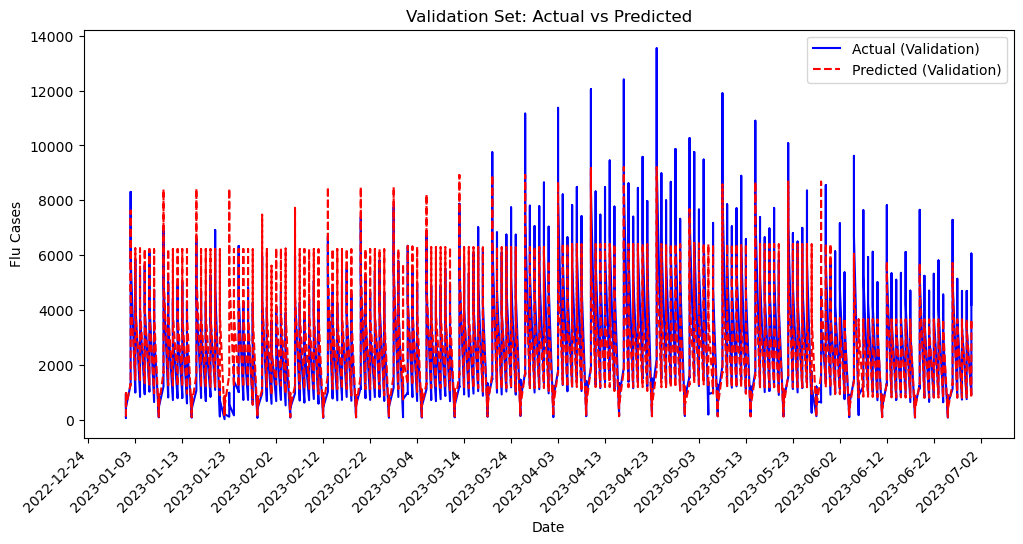

In [24]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# 검증 데이터에서 연, 월, 일을 사용해 날짜 생성
dates_val = pd.to_datetime(val_df[['year', 'month', 'day']])

# 검증 데이터 실제 값과 예측 값 비교 그래프
plt.figure(figsize=(12, 6))

# 실제 값과 예측 값 그래프
plt.plot(dates_val, y_val.values, label='Actual (Validation)', color='b')
plt.plot(dates_val, y_val_pred, label='Predicted (Validation)', color='r', linestyle='--')

# x축에 날짜 포맷 적용
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=10))

# x축 레이블과 회전
plt.gcf().autofmt_xdate(rotation=45)

# 그래프 제목과 레이블
plt.title('Validation Set: Actual vs Predicted')
plt.xlabel('Date')
plt.ylabel('Flu Cases')
plt.legend()

# 그래프 출력
plt.show()

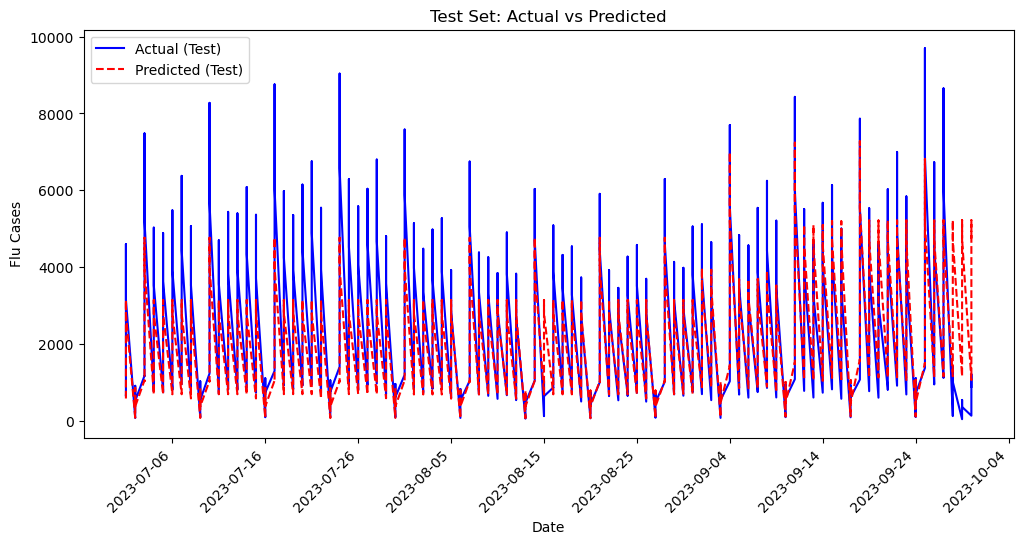

In [25]:
# 테스트 데이터에서 연, 월, 일을 사용해 날짜 생성
dates_test = pd.to_datetime(test_df[['year', 'month', 'day']])

# 테스트 데이터 실제 값과 예측 값 비교 그래프
plt.figure(figsize=(12, 6))

# 실제 값과 예측 값 그래프
plt.plot(dates_test, y_test.values, label='Actual (Test)', color='b')
plt.plot(dates_test, y_test_pred, label='Predicted (Test)', color='r', linestyle='--')

# x축에 날짜 포맷 적용
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=10))

# x축 레이블과 회전
plt.gcf().autofmt_xdate(rotation=45)

# 그래프 제목과 레이블
plt.title('Test Set: Actual vs Predicted')
plt.xlabel('Date')
plt.ylabel('Flu Cases')
plt.legend()

# 그래프 출력
plt.show()

5. 모델 개량 (차분 기법 적용, stacking 앙상블 기법)

Fitting 5 folds for each of 81 candidates, totalling 405 fits
Best RF params: {'max_depth': 20, 'min_samples_leaf': 2, 'min_samples_split': 10, 'n_estimators': 100}
Fitting 5 folds for each of 18 candidates, totalling 90 fits
Best GB params: {'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 200}
Fitting 5 folds for each of 18 candidates, totalling 90 fits


c:\Users\0214j\anaconda3\envs\Base\lib\site-packages\joblib\externals\loky\process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Best XGB params: {'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 100}
Train MAE: 155.80567229014872
Train RMSE: 254.57005954711155
Train MAPE: 11.399954376197329%
Validation MAE: 366.0018567374796
Validation RMSE: 521.9450610140027
Validation MAPE: 22.47528751951784%
Test MAE: 438.064038825277
Test RMSE: 691.9414763323637
Test MAPE: 45.140284976238725%


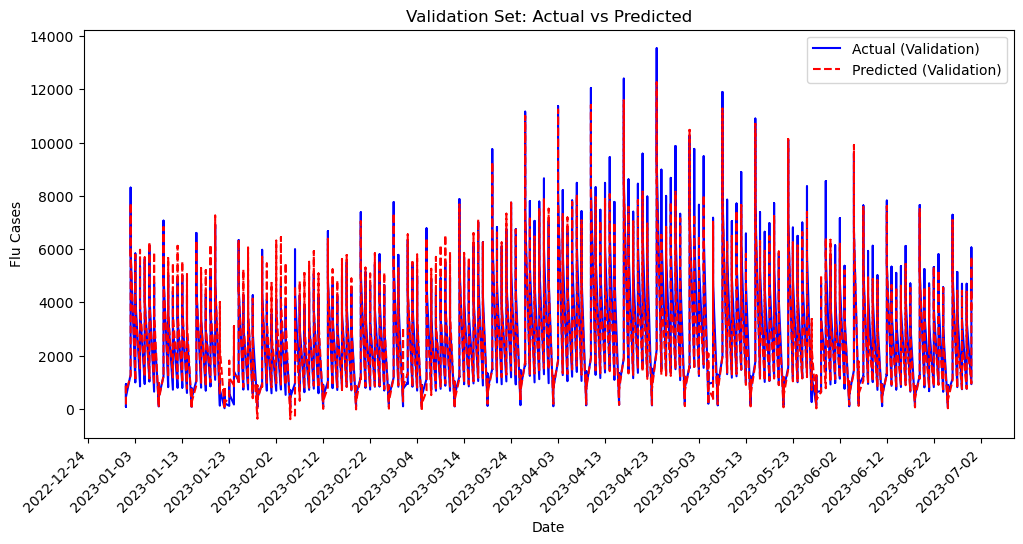

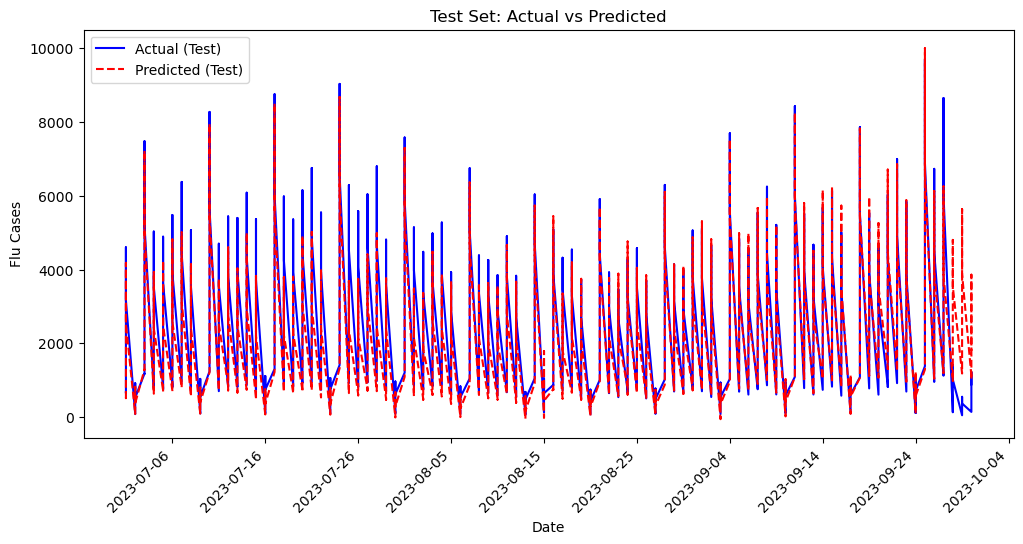

In [28]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import Ridge
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.ensemble import StackingRegressor
import xgboost as xgb

# 데이터 로드
data = pd.read_csv('county_data_without_14_20_21_22.csv', encoding='cp949')

# 날짜 관련 변수 추가
data['date'] = pd.to_datetime(data['date'])
data['year'] = data['date'].dt.year
data['month'] = data['date'].dt.month
data['day'] = data['date'].dt.day
data['weekday'] = data['date'].dt.dayofweek

# 차분 기법 (감기 발생 건수의 변화량)
data['diff_cold_cases'] = data['number of cold case'].diff().fillna(0)

# 날짜를 기준으로 정렬
data = data.sort_values(by=['year', 'month', 'day'])

# 데이터셋 분리
train_df = data[(data['year'] >= 2015) & (data['year'] <= 2019)]  # 2015~2019년 데이터
val_df = data[(data['year'] == 2023) & (data['month'] >= 1) & (data['month'] <= 6)]  # 2023년 1~6월 데이터
test_df = data[(data['year'] == 2023) & (data['month'] >= 7) & (data['month'] <= 9)]  # 2023년 7~9월 데이터

# 훈련, 검증, 테스트 데이터 준비
X_train = train_df[['year', 'month', 'day', 'weekday', 'county code', 'diff_cold_cases']]
y_train = train_df['number of cold case']
X_val = val_df[['year', 'month', 'day', 'weekday', 'county code', 'diff_cold_cases']]
y_val = val_df['number of cold case']
X_test = test_df[['year', 'month', 'day', 'weekday', 'county code', 'diff_cold_cases']]
y_test = test_df['number of cold case']

# -------------------------------
# 랜덤포레스트 하이퍼파라미터 최적화
param_grid_rf = {
    'n_estimators': [100, 200, 300],
    'max_depth': [10, 15, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

grid_search_rf = GridSearchCV(
    estimator=RandomForestRegressor(random_state=42),
    param_grid=param_grid_rf,
    scoring='neg_mean_squared_error',
    cv=5,
    n_jobs=-1,
    verbose=2
)

# 랜덤포레스트 최적의 하이퍼파라미터 탐색
grid_search_rf.fit(X_train, y_train)
best_rf = grid_search_rf.best_estimator_
print(f"Best RF params: {grid_search_rf.best_params_}")

# -------------------------------
# GradientBoosting 하이퍼파라미터 최적화
param_grid_gb = {
    'n_estimators': [100, 200],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 5, 7]
}

grid_search_gb = GridSearchCV(
    estimator=GradientBoostingRegressor(random_state=42),
    param_grid=param_grid_gb,
    scoring='neg_mean_squared_error',
    cv=5,
    n_jobs=-1,
    verbose=2
)

# GradientBoosting 최적의 하이퍼파라미터 탐색
grid_search_gb.fit(X_train, y_train)
best_gb = grid_search_gb.best_estimator_
print(f"Best GB params: {grid_search_gb.best_params_}")

# -------------------------------
# XGBoost 하이퍼파라미터 최적화
param_grid_xgb = {
    'n_estimators': [100, 200],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 5, 7]
}

grid_search_xgb = GridSearchCV(
    estimator=xgb.XGBRegressor(random_state=42),
    param_grid=param_grid_xgb,
    scoring='neg_mean_squared_error',
    cv=5,
    n_jobs=-1,
    verbose=2
)

# XGBoost 최적의 하이퍼파라미터 탐색
grid_search_xgb.fit(X_train, y_train)
best_xgb = grid_search_xgb.best_estimator_
print(f"Best XGB params: {grid_search_xgb.best_params_}")

# -------------------------------
# 최적화된 모델을 사용한 Stacking 앙상블 구성
estimators = [
    ('rf', best_rf),
    ('gb', best_gb),
    ('xgb', best_xgb)
]

stacking_model = StackingRegressor(
    estimators=estimators, final_estimator=Ridge(), cv=5
)

# Stacking 모델 학습
stacking_model.fit(X_train, y_train)

# -------------------------------
# MAPE 계산 함수
def mean_absolute_percentage_error(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

# 학습 데이터 예측 및 평가
y_train_pred = stacking_model.predict(X_train)
train_mae = mean_absolute_error(y_train, y_train_pred)
train_rmse = mean_squared_error(y_train, y_train_pred, squared=False)
train_mape = mean_absolute_percentage_error(y_train, y_train_pred)

print(f"Train MAE: {train_mae}")
print(f"Train RMSE: {train_rmse}")
print(f"Train MAPE: {train_mape}%")

# -------------------------------
# 검증 데이터 예측 및 평가
y_val_pred = stacking_model.predict(X_val)
val_mae = mean_absolute_error(y_val, y_val_pred)
val_rmse = mean_squared_error(y_val, y_val_pred, squared=False)
val_mape = mean_absolute_percentage_error(y_val, y_val_pred)

print(f"Validation MAE: {val_mae}")
print(f"Validation RMSE: {val_rmse}")
print(f"Validation MAPE: {val_mape}%")

# -------------------------------
# 테스트 데이터 예측 및 평가
y_test_pred = stacking_model.predict(X_test)
test_mae = mean_absolute_error(y_test, y_test_pred)
test_rmse = mean_squared_error(y_test, y_test_pred, squared=False)
test_mape = mean_absolute_percentage_error(y_test, y_test_pred)

print(f"Test MAE: {test_mae}")
print(f"Test RMSE: {test_rmse}")
print(f"Test MAPE: {test_mape}%")

# -------------------------------
# 그래프 시각화
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# 검증 데이터에서 연, 월, 일을 사용해 날짜 생성
dates_val = pd.to_datetime(val_df[['year', 'month', 'day']])

plt.figure(figsize=(12, 6))
plt.plot(dates_val, y_val.values, label='Actual (Validation)', color='b')
plt.plot(dates_val, y_val_pred, label='Predicted (Validation)', color='r', linestyle='--')
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=10))
plt.gcf().autofmt_xdate(rotation=45)
plt.title('Validation Set: Actual vs Predicted')
plt.xlabel('Date')
plt.ylabel('Flu Cases')
plt.legend()
plt.show()

# 테스트 데이터에서 연, 월, 일을 사용해 날짜 생성
dates_test = pd.to_datetime(test_df[['year', 'month', 'day']])

plt.figure(figsize=(12, 6))
plt.plot(dates_test, y_test.values, label='Actual (Test)', color='b')
plt.plot(dates_test, y_test_pred, label='Predicted (Test)', color='r', linestyle='--')
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=10))
plt.gcf().autofmt_xdate(rotation=45)
plt.title('Test Set: Actual vs Predicted')
plt.xlabel('Date')
plt.ylabel('Flu Cases')
plt.legend()
plt.show()
